In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
import os
import torch
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.io import wavfile
from sklearn.metrics import mean_squared_error
import statistics
from scipy.signal import savgol_filter, butter, filtfilt

class Config:
    def __init__(self, **kwargs):
        self.batch_size = kwargs.get('batch_size', 16)
        self.epochs = kwargs.get('epochs', 10)
        self.lr = kwargs.get('lr', 0.001)
        self.channels_imu_acc = kwargs.get('channels_imu_acc', [])
        self.channels_imu_acc_test = kwargs.get('channels_imu_acc_test', [])
        self.channels_imu_gyr_test = kwargs.get('channels_imu_gyr_test', [])
        self.channels_imu_gyr = kwargs.get('channels_imu_gyr', [])
        self.channels_joints = kwargs.get('channels_joints', [])
        self.channels_emg = kwargs.get('channels_emg', [])
        self.seed = kwargs.get('seed', 42)
        self.data_folder_name = kwargs.get('data_folder_name', 'default_data_folder_name')
        self.dataset_root = kwargs.get('dataset_root', 'default_dataset_root')
        self.dataset_train_name = kwargs.get('dataset_train_name', 'train')
        self.dataset_test_name = kwargs.get('dataset_test_name', 'test')
        self.window_length = kwargs.get('window_length', 100)
        self.window_overlap = kwargs.get('window_overlap', 0)
        self.imu_transforms = kwargs.get('imu_transforms', [])
        self.joint_transforms = kwargs.get('joint_transforms', [])
        self.emg_transforms = kwargs.get('emg_transforms', [])
        self.hidden_size = kwargs.get('hidden_size', 256)
        self.num_layers = kwargs.get('num_layers', 6)
        self.input_size = kwargs.get('input_size', 3)
        self.output_size = kwargs.get('output_size', 3)
        self.sample_rate = kwargs.get('sample_rate', 100)
        self.input_format = kwargs.get('input_format', 'csv')
        self.train_subjects = kwargs.get('train_subjects', [])
        self.test_subjects = kwargs.get('test_subjects', [])

        self.dataset_name = self.generate_dataset_name()

    def generate_dataset_name(self):
        name = f"dataset_wl{self.window_length}_ol{self.window_overlap}_train{self.train_subjects}_test{self.test_subjects}"
        return name

In [ ]:
class DataSharder:
    def __init__(self, config, save_h5=False):
        self.config = config
        self.sample_rate = config.sample_rate
        self.input_format = config.input_format
        self.data_folder_path = config.data_folder_name
        self.window_length = int(config.window_length)
        self.window_overlap = int(config.window_overlap)
        self.save_h5 = save_h5

    def load_data(self):
        print(f"Training subjects: {self.config.train_subjects}")
        print(f"Testing subjects: {self.config.test_subjects}")

        if self.input_format == 'wav':
            self._process_and_save_patients_wav(self.config.train_subjects, "train")
            self._process_and_save_patients_wav(self.config.test_subjects, "test")
        elif self.input_format == 'csv':
            self._process_and_save_patients_csv(self.config.train_subjects, "train")
            self._process_and_save_patients_csv(self.config.test_subjects, "test")
        else:
            raise ValueError(f"Unsupported input format: {self.input_format}")

    def _process_and_save_patients_wav(self, patient_id_list, split):
        total_data = []
        for patient_id in tqdm(patient_id_list, desc=f"Processing {split} patients"):
            for session_index in tqdm(range(len(self.config.train_subjects)), desc=f"Processing sessions for {patient_id}", leave=False):
                imu_data, imu_sample_rate = self._load_wav_file(patient_id, session_index, "IMU")
                joints_data, joints_sample_rate = self._load_wav_file(patient_id, session_index, "JOINTS")
                emg_data, emg_sample_rate = self._load_wav_file(patient_id, session_index, "EMG")

                imu_data = self._resample_data(imu_data, imu_sample_rate)
                joints_data = self._resample_data(joints_data, joints_sample_rate)
                emg_data = self._resample_data(emg_data, emg_sample_rate)

                combined_data = torch.cat((imu_data, joints_data, emg_data), dim=1)
                total_data.append(combined_data.cpu().numpy())

        if self.save_h5:
            self._save_to_h5(total_data, split)
        else:
            for combined_data in total_data:
                self._save_windowed_data(combined_data, patient_id, session_index, split)

    def _load_wav_file(self, patient_id, session_index, file_type):
        file_path = os.path.join(self.data_folder_path, patient_id, f"run{session_index}_{file_type}.wav")
        data, sample_rate = get_data_from_wav_file(file_path)
        return torch.tensor(data, dtype=torch.float32), sample_rate

    def _resample_data(self, data, sample_rate):
        if sample_rate != self.sample_rate:
            data = torch.nn.functional.interpolate(data.unsqueeze(0), size=self.sample_rate, mode='linear').squeeze(0)
        return data

    def _process_and_save_patients_csv(self, patient_id_list, split):
        column_names = None
        for patient_id in tqdm(patient_id_list, desc=f"Processing {split} patients"):
            combined_path = os.path.join(self.data_folder_path, patient_id, "combined")
            if not os.path.exists(combined_path):
                print(f"Directory {combined_path} does not exist. Skipping patient {patient_id}.")
                continue

            patient_files = os.listdir(combined_path)
            for session_file in tqdm(patient_files, desc=f"Processing sessions for {patient_id}", leave=False):
                data = pd.read_csv(os.path.join(combined_path, session_file))
                if column_names is None:
                    column_names = data.columns.tolist()  # Convert Index to list
                data_np = data.to_numpy()
                # Pad array to fit columns if necessary
                if data_np.shape[1] < len(column_names):
                    data_np = np.pad(data_np, ((0, 0), (0, len(column_names) - data_np.shape[1])), mode='constant')
                elif data_np.shape[1] > len(column_names):
                    # Extend column names to match the data shape
                    extra_columns = [f"extra_{i}" for i in range(data_np.shape[1] - len(column_names))]
                    column_names.extend(extra_columns)

                self._save_windowed_data(pd.DataFrame(data_np, columns=column_names), patient_id, session_file.split('.')[0], split, is_csv=True)

    def _save_windowed_data(self, data, patient_id, session_id, split, is_csv=False):
        dataset_folder = os.path.join(self.config.dataset_root, self.config.dataset_name, self.config.dataset_train_name if split == "train" else self.config.dataset_test_name)
        os.makedirs(dataset_folder, exist_ok=True)

        window_size = self.window_length
        overlap = self.window_overlap
        step_size = window_size - overlap

        data_info_list = []

        for i in tqdm(range(0, len(data) - window_size + 1, step_size), desc=f"Windowing data for {patient_id}_{session_id}", leave=False):
            windowed_data = data.iloc[i:i+window_size] if is_csv else data[i:i+window_size]
            if windowed_data.shape[0] < window_size:
                continue

            windowed_data_np = windowed_data.to_numpy() if is_csv else windowed_data.cpu().numpy()

            file_name = f"{patient_id}_session_{session_id}_window_{i}_ws{window_size}_ol{overlap}.csv"
            file_path = os.path.join(dataset_folder, file_name)
            pd.DataFrame(windowed_data_np, columns=data.columns if is_csv else None).to_csv(file_path, index=False)
            data_info_list.append({"file_name": file_name, "file_path": file_path})

        data_info_df = pd.DataFrame(data_info_list)
        data_info_df.to_csv(os.path.join(self.config.dataset_root, self.config.dataset_name, f"{split}_info.csv"), index=False, mode='a', header=not os.path.exists(os.path.join(self.config.dataset_root, self.config.dataset_name, f"{split}_info.csv")))


In [ ]:
class ImuJointPairDataset(Dataset):
    def __init__(self, config, split='train'):
        self.config = config
        self.split = split
        self.input_format = config.input_format
        self.channels_imu_acc = config.channels_imu_acc
        self.channels_imu_acc_test = config.channels_imu_acc_test
        self.channels_imu_gyr = config.channels_imu_gyr
        self.channels_imu_gyr_test = config.channels_imu_gyr_test
        self.channels_joints = config.channels_joints
        self.channels_emg = config.channels_emg

        dataset_name = self.config.dataset_name
        self.root_dir_train = os.path.join(self.config.dataset_root, dataset_name, self.config.dataset_train_name)
        self.root_dir_test = os.path.join(self.config.dataset_root, dataset_name, self.config.dataset_test_name)

        train_info_path = os.path.join(self.config.dataset_root, dataset_name, "train_info.csv")
        test_info_path = os.path.join(self.config.dataset_root, dataset_name, "test_info.csv")
        self.data = pd.read_csv(train_info_path) if split == 'train' else pd.read_csv(test_info_path)

        self.scaler_save_path = os.path.join(self.config.dataset_root, dataset_name, "scaler.pkl")
        self.scaler = joblib.load(self.scaler_save_path) if os.path.exists(self.scaler_save_path) else None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.split == "train":
            file_path = os.path.join(self.root_dir_train, self.data.iloc[idx, 0])
        else:
            file_path = os.path.join(self.root_dir_test, self.data.iloc[idx, 0])

        if self.input_format == "wav":
            combined_data, _ = get_data_from_wav_file(file_path)
        elif self.input_format == "csv":
            combined_data = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported input format: {}".format(self.input_format))

        imu_data_acc, imu_data_gyr, joint_data, emg_data = self._extract_and_transform(combined_data)
        windows = self._apply_windowing(imu_data_acc, imu_data_gyr, joint_data, emg_data, self.config.window_length, self.config.window_overlap)

        acc_concat = np.concatenate([w[0] for w in windows], axis=0)
        gyr_concat = np.concatenate([w[1] for w in windows], axis=0)
        joint_concat = np.concatenate([w[2] for w in windows], axis=0)
        emg_concat = np.concatenate([w[3] for w in windows], axis=0)

        return acc_concat, gyr_concat, joint_concat, emg_concat

    def _extract_and_transform(self, combined_data):
        imu_data_acc = self._extract_channels(combined_data, self.channels_imu_acc)
        imu_data_gyr = self._extract_channels(combined_data, self.channels_imu_gyr)
        joint_data = self._extract_channels(combined_data, self.channels_joints)
        emg_data = self._extract_channels(combined_data, self.channels_emg)

        combined_data = np.concatenate([imu_data_acc, imu_data_gyr, joint_data, emg_data], axis=1)
        scaled_data = combined_data

        imu_data_acc = scaled_data[:, :imu_data_acc.shape[1]]
        imu_data_gyr = scaled_data[:, imu_data_acc.shape[1]:imu_data_acc.shape[1] + imu_data_gyr.shape[1]]
        joint_data = scaled_data[:, imu_data_acc.shape[1] + imu_data_gyr.shape[1]:imu_data_acc.shape[1] + imu_data_gyr.shape[1] + joint_data.shape[1]]
        emg_data = scaled_data[:, imu_data_acc.shape[1] + imu_data_gyr.shape[1] + joint_data.shape[1]:]

        imu_data_acc = self.apply_transforms(imu_data_acc, self.config.imu_transforms)
        imu_data_gyr = self.apply_transforms(imu_data_gyr, self.config.imu_transforms)
        joint_data = self.apply_transforms(joint_data, self.config.joint_transforms)
        emg_data = self.apply_transforms(emg_data, self.config.emg_transforms)

        return imu_data_acc, imu_data_gyr, joint_data, emg_data

    def _extract_channels(self, combined_data, channels):
        if isinstance(channels, slice):
            return combined_data.iloc[:, channels].values if self.input_format == "csv" else combined_data[:, channels]
        else:
            return combined_data[channels].values if self.input_format == "csv" else combined_data[:, channels]

    def _apply_windowing(self, imu_data_acc, imu_data_gyr, joint_data, emg_data, window_length, window_overlap):
        num_samples = imu_data_acc.shape[0]
        step = window_length - window_overlap
        windows = []

        for start in range(0, num_samples - window_length + 1, step):
            end = start + window_length
            window = (
                imu_data_acc[start:end],
                imu_data_gyr[start:end],
                joint_data[start:end],
                emg_data[start:end]
            )
            windows.append(window)

        return windows

    def apply_transforms(self, data, transforms):
        for transform in transforms:
            data = transform(data)
        data = torch.tensor(data, dtype=torch.float32)
        return data


In [ ]:
#prediction function
def RMSE_prediction(yhat_4,test_y, output_dim):

  s1=yhat_4.shape[0]*yhat_4.shape[1]

  test_o=test_y.reshape((s1,output_dim))
  yhat=yhat_4.reshape((s1,output_dim))




  y_1_no=yhat[:,0]
  y_2_no=yhat[:,1]
  y_3_no=yhat[:,2]
  #y_4_no=yhat[:,3]
  #y_5_no=yhat[:,4]
  #y_6_no=yhat[:,5]
  #y_7_no=yhat[:,6]
  #y_8_no=yhat[:,7]
  #y_9_no=yhat[:,8]
  #y_10_no=yhat[:,9]


  y_1=y_1_no
  y_2=y_2_no
  y_3=y_3_no
  #y_4=y_4_no
  #y_5=y_5_no
  #y_6=y_6_no
  #y_7=y_7_no



  y_test_1=test_o[:,0]
  y_test_2=test_o[:,1]
  y_test_3=test_o[:,2]
  #y_test_4=test_o[:,3]
  #y_test_5=test_o[:,4]
  #y_test_6=test_o[:,5]
  #y_test_7=test_o[:,6]
  #y_test_8=test_o[:,7]
  #y_test_9=test_o[:,8]
  #y_test_10=test_o[:,9]





  #print(y_1.shape,y_test_1.shape)


  cutoff=6
  fs=200
  order=4

  nyq = 0.5 * fs
  ## filtering data ##
  def butter_lowpass_filter(data, cutoff, fs, order):
      normal_cutoff = cutoff / nyq
      # Get the filter coefficients
      b, a = butter(order, normal_cutoff, btype='low', analog=False)
      y = filtfilt(b, a, data)
      return y



  # y_1=butter_lowpass_filter(y_1_no, cutoff, fs, order)
  # y_2=butter_lowpass_filter(y_2_no, cutoff, fs, order)
  # y_3=butter_lowpass_filter(y_3_no, cutoff, fs, order)
  # y_4=butter_lowpass_filter(y_4_no, cutoff, fs, order)
  # y_5=butter_lowpass_filter(y_5_no, cutoff, fs, order)
  # y_6=butter_lowpass_filter(y_6_no, cutoff, fs, order)
  # y_7=butter_lowpass_filter(y_7_no, cutoff, fs, order)
  #y_8=butter_lowpass_filter(y_8_no, cutoff, fs, order)
  #y_9=butter_lowpass_filter(y_9_no, cutoff, fs, order)
  #y_10=butter_lowpass_filter(y_10_no, cutoff, fs, order)




  Z_1=y_1
  Z_2=y_2
  Z_3=y_3
  #Z_4=y_4
  #Z_5=y_5
  #Z_6=y_6
  #Z_7=y_7
  #Z_8=y_8
  #Z_9=y_9
  #Z_10=y_10



  ###calculate RMSE

  rmse_1 =((np.sqrt(mean_squared_error(y_test_1,y_1))))
  rmse_2 =((np.sqrt(mean_squared_error(y_test_2,y_2))))
  rmse_3 =((np.sqrt(mean_squared_error(y_test_3,y_3))))
  #rmse_4 =((np.sqrt(mean_squared_error(y_test_4,y_4)))/(max(y_test_4)-min(y_test_4)))*100
  #rmse_5 =((np.sqrt(mean_squared_error(y_test_5,y_5)))/(max(y_test_5)-min(y_test_5)))*100
  #rmse_6 =((np.sqrt(mean_squared_error(y_test_6,y_6)))/(max(y_test_6)-min(y_test_6)))*100
  #rmse_7 =((np.sqrt(mean_squared_error(y_test_7,y_7)))/(max(y_test_7)-min(y_test_7)))*100
  #rmse_8 =((np.sqrt(mean_squared_error(y_test_8,y_8)))/(max(y_test_8)-min(y_test_8)))*100
  #rmse_9 =((np.sqrt(mean_squared_error(y_test_9,y_9)))/(max(y_test_9)-min(y_test_9)))*100
  #rmse_10 =((np.sqrt(mean_squared_error(y_test_10,y_10)))/(max(y_test_10)-min(y_test_10)))*100


  print(rmse_1)
  print(rmse_2)
  print(rmse_3)
  #print(rmse_4)
  #print(rmse_5)
  #print(rmse_6)
  #print(rmse_7)
  #print(rmse_8)
  #print(rmse_9)
  #print(rmse_10)


  p_1=np.corrcoef(y_1, y_test_1)[0, 1]
  p_2=np.corrcoef(y_2, y_test_2)[0, 1]
  p_3=np.corrcoef(y_3, y_test_3)[0, 1]
  #p_4=np.corrcoef(y_4, y_test_4)[0, 1]
  #p_5=np.corrcoef(y_5, y_test_5)[0, 1]
  #p_6=np.corrcoef(y_6, y_test_6)[0, 1]
  #p_7=np.corrcoef(y_7, y_test_7)[0, 1]
  #p_8=np.corrcoef(y_8, y_test_8)[0, 1]
  #p_9=np.corrcoef(y_9, y_test_9)[0, 1]
  #p_10=np.corrcoef(y_10, y_test_10)[0, 1]


  print("\n")
  print(p_1)
  print(p_2)
  print(p_3)
  #print(p_4)
  #print(p_5)
  #print(p_6)
  #print(p_7)
  #print(p_8)
  #print(p_9)
  #print(p_10)


              ### Correlation ###
  p=np.array([p_1,p_2,p_3])
  #,p_4,p_5,p_6,p_7])




      #### Mean and standard deviation ####

  rmse=np.array([rmse_1,rmse_2,rmse_3])
  #,rmse_4,rmse_5,rmse_6,rmse_7])

      #### Mean and standard deviation ####
  m=statistics.mean(rmse)
  SD=statistics.stdev(rmse)
  print('Mean: %.3f' % m,'+/- %.3f' %SD)

  m_c=statistics.mean(p)
  SD_c=statistics.stdev(p)
  print('Mean: %.3f' % m_c,'+/- %.3f' %SD_c)



  return rmse, p, Z_1,Z_2,Z_3
  #,Z_4,Z_5,Z_6,Z_7



############################################################################################################################################################################################################################################################################################################################################################################################################################################################################


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
class Encoder_1(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_1, self).__init__()
        self.lstm_1 = nn.LSTM(input_dim, 128, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.LSTM(256, 64, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2




class Encoder_2(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_2, self).__init__()
        self.lstm_1 = nn.GRU(input_dim, 128, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.GRU(256, 64, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2


class GatingModule(nn.Module):
    def __init__(self, input_size):
        super(GatingModule, self).__init__()
        self.gate = nn.Sequential(
            nn.Linear(2*input_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, input1, input2):
        # Apply gating mechanism
        gate_output = self.gate(torch.cat((input1,input2),dim=-1))

        # Scale the inputs based on the gate output
        gated_input1 = input1 * gate_output
        gated_input2 = input2 * (1 - gate_output)

        # Combine the gated inputs
        output = gated_input1 + gated_input2
        return output
#variable w needs to be checked for correct value, stand-in value used
class teacher(nn.Module):
    def __init__(self, input_acc, input_gyr, input_emg, drop_prob=0.25, w=100):
        super(teacher, self).__init__()

        self.w=w
        self.encoder_1_acc=Encoder_1(input_acc, drop_prob)
        self.encoder_1_gyr=Encoder_1(input_gyr, drop_prob)
        self.encoder_1_emg=Encoder_1(input_emg, drop_prob)

        self.encoder_2_acc=Encoder_2(input_acc, drop_prob)
        self.encoder_2_gyr=Encoder_2(input_gyr, drop_prob)
        self.encoder_2_emg=Encoder_2(input_emg, drop_prob)

        self.BN_acc= nn.BatchNorm1d(input_acc, affine=False)
        self.BN_gyr= nn.BatchNorm1d(input_gyr, affine=False)
        self.BN_emg= nn.BatchNorm1d(input_emg, affine=False)


        self.fc = nn.Linear(2*3*128+128,3)
        self.dropout=nn.Dropout(p=0.05)

        self.gate_1=GatingModule(128)
        self.gate_2=GatingModule(128)
        self.gate_3=GatingModule(128)

        self.fc_kd = nn.Linear(3*128, 2*128)

               # Define the gating network
        self.weighted_feat = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid())

        self.attention=nn.MultiheadAttention(3*128,4,batch_first=True)
        self.gating_net = nn.Sequential(nn.Linear(128*3, 3*128), nn.Sigmoid())
        self.gating_net_1 = nn.Sequential(nn.Linear(2*3*128+128, 2*3*128+128), nn.Sigmoid())

        self.pool = nn.MaxPool1d(kernel_size=2)


    def forward(self, x_acc, x_gyr, x_emg):

        x_acc_1=x_acc.view(x_acc.size(0)*x_acc.size(1),x_acc.size(-1))
        x_gyr_1=x_gyr.view(x_gyr.size(0)*x_gyr.size(1),x_gyr.size(-1))
        x_emg_1=x_emg.view(x_emg.size(0)*x_emg.size(1),x_emg.size(-1))

        x_acc_1=self.BN_acc(x_acc_1)
        x_gyr_1=self.BN_gyr(x_gyr_1)
        x_emg_1=self.BN_emg(x_emg_1)

        x_acc_2=x_acc_1.view(-1, self.w, x_acc_1.size(-1))
        x_gyr_2=x_gyr_1.view(-1, self.w, x_gyr_1.size(-1))
        x_emg_2=x_emg_1.view(-1, self.w, x_emg_1.size(-1))

        x_acc_1=self.encoder_1_acc(x_acc_2)
        x_gyr_1=self.encoder_1_gyr(x_gyr_2)
        x_emg_1=self.encoder_1_emg(x_emg_2)

        x_acc_2=self.encoder_2_acc(x_acc_2)
        x_gyr_2=self.encoder_2_gyr(x_gyr_2)
        x_emg_2=self.encoder_2_emg(x_emg_2)

        # x_acc=torch.cat((x_acc_1,x_acc_2),dim=-1)
        # x_gyr=torch.cat((x_gyr_1,x_gyr_2),dim=-1)
        # x_emg=torch.cat((x_emg_1,x_emg_2),dim=-1)

        x_acc=self.gate_1(x_acc_1,x_acc_2)
        x_gyr=self.gate_2(x_gyr_1,x_gyr_2)
        x_emg=self.gate_3(x_emg_1,x_emg_2)

        x=torch.cat((x_acc,x_gyr,x_emg),dim=-1)
        x_kd=self.fc_kd(x)


        out_1, attn_output_weights=self.attention(x,x,x)

        gating_weights = self.gating_net(x)
        out_2=gating_weights*x

        weights_1 = self.weighted_feat(x[:,:,0:128])
        weights_2 = self.weighted_feat(x[:,:,128:2*128])
        weights_3 = self.weighted_feat(x[:,:,2*128:3*128])
        x_1=weights_1*x[:,:,0:128]
        x_2=weights_2*x[:,:,128:2*128]
        x_3=weights_3*x[:,:,2*128:3*128]
        out_3=x_1+x_2+x_3

        out=torch.cat((out_1,out_2,out_3),dim=-1)

        gating_weights_1 = self.gating_net_1(out)
        out=gating_weights_1*out

        out=self.fc(out)

        #print(out.shape)
        return out,x_kd


class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
    def forward(self, output, target):
        loss = torch.sqrt(torch.mean((output - target) ** 2))
        return loss




In [ ]:
def train_teacher(device, train_loader, val_loader, learn_rate, epochs, model, filename):
    if torch.cuda.is_available():
        model.cuda()

    criterion = RMSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    train_losses = []
    val_losses = []

    start_time = time.time()
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        epoch_train_loss = np.zeros(len(config.channels_joints))
        epoch_val_loss = np.zeros(len(config.channels_joints))

        for data_acc, data_gyr, target, data_EMG in train_loader:
            optimizer.zero_grad()
            output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
            loss = criterion(output, target.to(device).float())
            loss.backward()
            optimizer.step()

            batch_loss = np.mean((output.detach().cpu().numpy() - target.detach().cpu().numpy())**2, axis=(0, 1))
            epoch_train_loss += batch_loss

        train_losses.append(epoch_train_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            for data_acc, data_gyr, target, data_EMG in val_loader:
                output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
                batch_loss = np.mean((output.detach().cpu().numpy() - target.detach().cpu().numpy())**2, axis=(0, 1))
                epoch_val_loss += batch_loss

        val_losses.append(epoch_val_loss / len(val_loader))

        epoch_end_time = time.time()
        epoch_training_time = epoch_end_time - epoch_start_time

        print(f"Epoch: {epoch + 1}, time: {epoch_training_time:.4f}, Training Loss: {train_losses[-1].mean():.4f}, Validation Loss: {val_losses[-1].mean():.4f}")

        if val_losses[-1].mean() < best_val_loss:
            best_val_loss = val_losses[-1].mean()
            torch.save(model.state_dict(), filename)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early after {epoch + 1} epochs")
            break

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time} seconds")

    return model, train_losses, val_losses


In [ ]:
def evaluate_model(model, loader, output_dim=3):
    model.eval()
    yhat_5 = []
    test_target = []

    with torch.no_grad():
        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(loader):
            output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
            yhat_5.append(output)
            test_target.append(target)

            # clear memory
            del data_acc, data_gyr, target, data_EMG, output
            torch.cuda.empty_cache()

    yhat_4 = torch.cat(yhat_5, dim=0).detach().cpu().numpy()
    test_target = torch.cat(test_target, dim=0).detach().cpu().numpy()
    print(yhat_4.shape)

    rmse, p, Z_1, Z_2, Z_3 = RMSE_prediction(yhat_4, test_target, output_dim=output_dim)
    return np.hstack([rmse, p])


In [ ]:
def process_file(file_path, teacher_model):
    df = pd.read_csv(file_path)
    print("processing file {}".format(file_path))

    columns_imu_acc = config.channels_imu_acc
    columns_imu_gyr = config.channels_imu_gyr
    columns_joints = config.channels_joints

    input_acc = df[columns_imu_acc].values
    input_gyr = df[columns_imu_gyr].values
    input_emg = df[config.channels_emg].values
    target_data = df[columns_joints].values

    acc_tensor = torch.tensor(input_acc, dtype=torch.float32).unsqueeze(0)
    gyr_tensor = torch.tensor(input_gyr, dtype=torch.float32).unsqueeze(0)
    emg_tensor = torch.tensor(input_emg, dtype=torch.float32).unsqueeze(0)
    target_tensor = torch.tensor(target_data, dtype=torch.float32).unsqueeze(0)

    window_size = 100
    predictions_teacher = []

    with torch.no_grad():
        for i in range(0, acc_tensor.shape[1] - window_size + 1, window_size):
            acc_window = acc_tensor[:, i:i + window_size, :].to(device)
            gyr_window = gyr_tensor[:, i:i + window_size, :].to(device)
            emg_window = emg_tensor[:, i:i + window_size, :].to(device)

            output, _ = teacher_model(acc_window, gyr_window, emg_window)
            predictions_teacher.append(output.cpu().numpy())

    predictions_teacher = np.concatenate(predictions_teacher, axis=1)
    predictions_teacher = predictions_teacher.reshape(-1, predictions_teacher.shape[-1])
    target_tensor_np = target_tensor.cpu().numpy().squeeze(0)[:predictions_teacher.shape[0]]

    # Plot predictions vs ground truth for each channel
    num_channels = predictions_teacher.shape[1]

    fig, axes = plt.subplots(1, num_channels, figsize=(5 * num_channels, 5))

    for channel in range(num_channels):
        ax = axes[channel]
        ax.plot(target_tensor_np[:1000, channel], label='Ground Truth')
        ax.plot(predictions_teacher[:1000, channel], label='Teacher Predicted')
        ax.set_title(f'{os.path.basename(file_path)} - Channel {channel + 1}')
        ax.set_xlabel('Samples')
        ax.set_ylabel('Value')
        ax.set_ylim(-180, 180)
        ax.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config(
    data_folder_name='/content/MyDrive/MyDrive/sd_datacollection_v2',
    dataset_root='/content/MyDrive/MyDrive/datasets_v2',
    dataset_train_name='train',
    dataset_test_name='test',
    batch_size=64,
    epochs=10,
    lr=0.001,
    window_length=100,
    window_overlap=75,
    input_format="csv",
    channels_imu_acc=['ACCX1', 'ACCY1', 'ACCZ1', 'ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_acc_test=['ACCX1', 'ACCY1', 'ACCZ1', 'ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_gyr=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_imu_gyr_test=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_joints=['elbow_flex_r', 'arm_flex_r', 'arm_add_r'],
    channels_emg=['IM EMG4', 'IM EMG5', 'IM EMG6'],
    train_subjects=['subject_1', 'subject_2'],
    test_subjects=['subject_3']
)
subjects = ['subject_1', 'subject_2', 'subject_3','subject_6', 'subject_7', 'subject_9']



In [ ]:
import itertools
import os
import glob
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def load_or_reshard_data(config):
    dataset_name = config.generate_dataset_name()
    dataset_path = os.path.join(config.dataset_root, dataset_name)
    if not os.path.exists(dataset_path):
        data_sharder = DataSharder(config)
        data_sharder.load_data()
    else:
        print(f"Dataset {dataset_name} already exists. Skipping resharding.")

def evaluate_and_save_rmse_per_channel(model, loader):
    model.eval()
    yhat_5 = []
    test_target = []

    with torch.no_grad():
        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(loader):
            output, x_1 = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
            yhat_5.append(output)
            test_target.append(target)

            # Clear memory
            del data_acc, data_gyr, data_EMG, target, output
            torch.cuda.empty_cache()

    yhat_4 = torch.cat(yhat_5, dim=0).detach().cpu().numpy()
    test_target = torch.cat(test_target, dim=0).detach().cpu().numpy()

    num_channels = yhat_4.shape[2]
    rmse_per_channel = np.zeros(num_channels)
    for channel in range(num_channels):
        rmse_per_channel[channel] = np.sqrt(mean_squared_error(test_target[:, :, channel], yhat_4[:, :, channel]))

    print(f'RMSE per channel: {rmse_per_channel}')

    rmse, p, Z_1, Z_2, Z_3 = RMSE_prediction(yhat_4, test_target, output_dim=3)
    return rmse_per_channel, rmse, p

subjects = ['subject_1', 'subject_2', 'subject_3', 'subject_6', 'subject_7', 'subject_9']

# Create directories for saving results and models
results_dir = '/content/MyDrive/MyDrive/models/Vanilla_SD_csv_RMSE_gridsearchtraining_smalldataset_fulldata'
os.makedirs(results_dir, exist_ok=True)

def plot_and_display_loss_curves(train_losses, val_losses, num_channels):
    plt.figure(figsize=(10, 5))
    plt.plot([np.mean(epoch) for epoch in train_losses], label='Training Loss')
    plt.plot([np.mean(epoch) for epoch in val_losses], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))

    # Plot individual channel losses
    for channel in range(num_channels):
        plt.plot([epoch[channel] for epoch in train_losses], label=f'Training Loss Channel {channel + 1}')
        plt.plot([epoch[channel] for epoch in val_losses], label=f'Validation Loss Channel {channel + 1}',linestyle="dashed")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curves for Channel {channel + 1}')
    plt.legend()
    plt.grid(True)
    plt.show()



results = []

processed_combinations = set()

for test_subject in subjects:
  for train_subjects in itertools.combinations(subjects, len(subjects) - 1):
      if test_subject in train_subjects:
          continue
      # Sort to avoid duplicate combinations like ['subject_1', 'subject_2'] and ['subject_2', 'subject_1']
      train_subjects = tuple(sorted(train_subjects))
      if train_subjects in processed_combinations:
          continue
      processed_combinations.add(train_subjects)

      config.train_subjects = train_subjects
      config.test_subjects = [test_subject]

      # Change dataset name in config
      config.dataset_name = config.generate_dataset_name()

      print(f'Training subjects: {train_subjects}')
      print(f'Testing subject: {test_subject}')
      print(f'Dataset name: {config.dataset_name}')
      # Data Sharding
      load_or_reshard_data(config)

      # Create datasets
      train_dataset = ImuJointPairDataset(config, split='train')
      test_dataset = ImuJointPairDataset(config, split='test')

      # Setup validation dataset
      train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)

      # Setup dataloaders
      train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
      val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
      test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

      # Train the model
      model = teacher(
          input_acc=len(config.channels_imu_acc),
          input_gyr=len(config.channels_imu_gyr),
          input_emg=len(config.channels_emg)
      )
      model_path = os.path.join(results_dir, f'teacher_model_train_{train_subjects}_test_{test_subject}.pth')
      trained_model, train_losses, val_losses = train_teacher(device, train_loader, val_loader, config.lr, config.epochs, model, filename=model_path)

      # Load the trained model
      trained_model.load_state_dict(torch.load(model_path))
      trained_model.to(device)
      trained_model.eval()

      # Evaluate the model
      print("________________________________\nTraining set metrics")
      train_results = evaluate_and_save_rmse_per_channel(trained_model, train_loader)
      print("________________________________\nValidation set metrics")
      val_results = evaluate_and_save_rmse_per_channel(trained_model, val_loader)
      print("________________________________\nTest set metrics")
      test_results = evaluate_and_save_rmse_per_channel(trained_model, test_loader)

      # Save individual CSVs for model performance
      train_results_df = pd.DataFrame({
          'rmse_per_channel': train_results[0],
          'train_rmse': train_results[1],
          'train_p': train_results[2]
      })
      train_results_df.to_csv(os.path.join(results_dir, f'train_results_{train_subjects}_test_{test_subject}.csv'), index=False)

      val_results_df = pd.DataFrame({
          'rmse_per_channel': val_results[0],
          'val_rmse': val_results[1],
          'val_p': val_results[2]
      })
      val_results_df.to_csv(os.path.join(results_dir, f'val_results_{train_subjects}_test_{test_subject}.csv'), index=False)

      test_results_df = pd.DataFrame({
          'rmse_per_channel': test_results[0],
          'test_rmse': test_results[1],
          'test_p': test_results[2]
      })
      test_results_df.to_csv(os.path.join(results_dir, f'test_results_{train_subjects}_test_{test_subject}.csv'), index=False)

      # Display loss curves
      plot_and_display_loss_curves(train_losses, val_losses, len(config.channels_joints))

      # Process files for the current test subject
      combined_folder_path = f'/content/MyDrive/MyDrive/sd_datacollection_v2/{test_subject}/combined/'
      file_paths = glob.glob(os.path.join(combined_folder_path, '*.csv'))
      print(f'Found {len(file_paths)} files for processing.')

      for file_path in file_paths:
          print(f'Processing file: {file_path}')
          process_file(file_path, trained_model)

      results.append({
          'train_subjects': train_subjects,
          'test_subject': test_subject,
          'train_rmse_per_channel': train_results[0],
          'train_results': train_results[1:],
          'val_rmse_per_channel': val_results[0],
          'val_results': val_results[1:],
          'test_rmse_per_channel': test_results[0],
          'test_results': test_results[1:]
      })

      print("End of iteration\n_________________________________________________________")

# Save the overall results
results_df = pd.DataFrame(results)
save_path = os.path.join(results_dir, 'grid_search_results.csv')
results_df.to_csv(save_path, index=False)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Check available columns in results_df
print("Available columns in results_df:")
print(results_df.columns)

# Display the summary of all RMSE values along with train and test subjects
summary_columns = ['train_subjects', 'test_subject', 'test_rmse_per_channel']

# Check for additional available columns and include them if they exist
optional_columns = ['train_rmse', 'val_rmse', 'test_rmse', 'train_p', 'val_p', 'test_p']
for col in optional_columns:
    if col in results_df.columns:
        summary_columns.append(col)

# Create the summary DataFrame with available columns
summary_df = results_df[summary_columns]

print("RMSE Summary and Additional Metrics:")
print(summary_df)


Available columns in results_df:
Index(['train_subjects', 'test_subject', 'train_rmse_per_channel',
       'train_results', 'val_rmse_per_channel', 'val_results',
       'test_rmse_per_channel', 'test_results'],
      dtype='object')
RMSE Summary and Additional Metrics:
                                      train_subjects test_subject  \
0  ('subject_2', 'subject_3', 'subject_6', 'subje...    subject_1   
1  ('subject_1', 'subject_3', 'subject_6', 'subje...    subject_2   
2  ('subject_1', 'subject_2', 'subject_6', 'subje...    subject_3   
3  ('subject_1', 'subject_2', 'subject_3', 'subje...    subject_6   
4  ('subject_1', 'subject_2', 'subject_3', 'subje...    subject_7   
5  ('subject_1', 'subject_2', 'subject_3', 'subje...    subject_9   

                       test_rmse_per_channel  
0    [32.40018463, 22.09160423, 14.27005291]  
1     [25.41135216, 29.1463871, 12.92563152]  
2      [29.0836525, 23.96167183, 7.24001694]  
3  [23.85437775, 120.87078857, 105.30945587]  
4    [44.2

<ipython-input-32-77ea2d9231b5>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='test_subject', y='mean_test_rmse', data=results_df, palette='viridis', edgecolor="k")


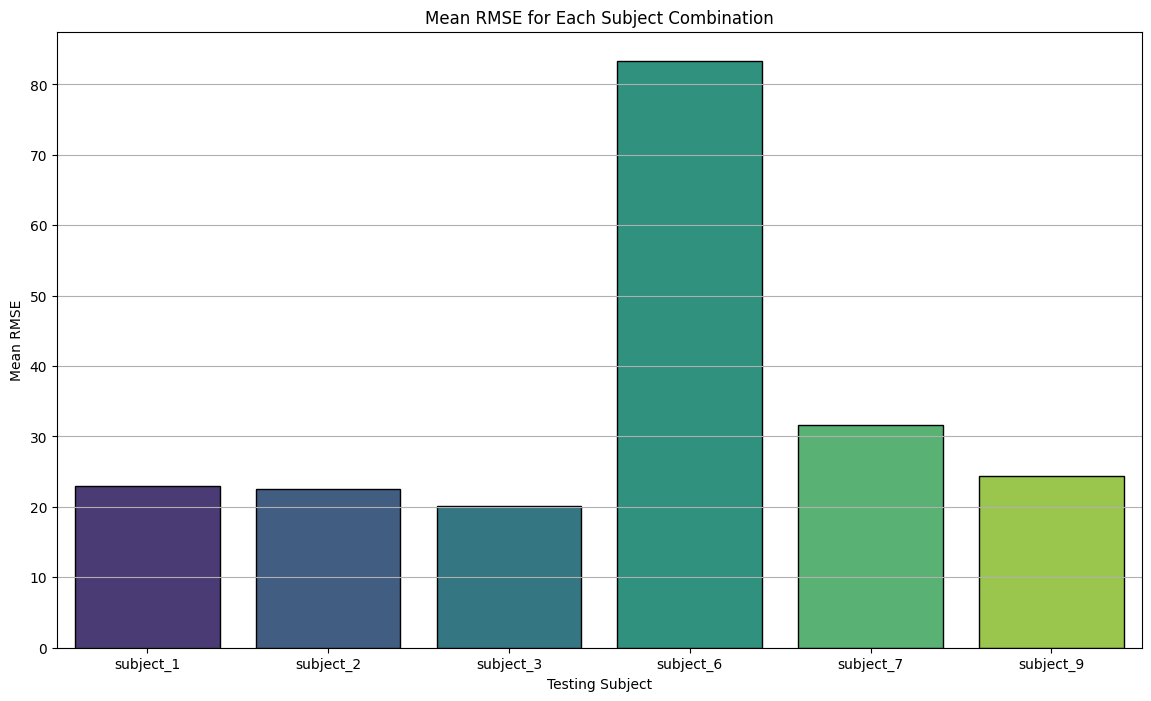

RMSE Summary and Additional Metrics:


,train_subjects,test_subject,train_rmse_per_channel,val_rmse_per_channel,test_rmse_per_channel,mean_test_rmse
0,"('subject_2', 'subject_3', 'subject_6', 'subje...",subject_1,[5.61447859 6.73327923 4.17933512],[5.81103659 8.34752369 4.11909437],"[32.40018463, 22.09160423, 14.27005291]",22.920614
1,"('subject_1', 'subject_3', 'subject_6', 'subje...",subject_2,[5.28417826 7.42501259 4.66005182],[5.52280569 8.18595028 4.60231066],"[25.41135216, 29.1463871, 12.92563152]",22.494457
2,"('subject_1', 'subject_2', 'subject_6', 'subje...",subject_3,[5.63194084 7.83972883 5.44659138],[5.54667997 7.53944016 5.47007847],"[29.0836525, 23.96167183, 7.24001694]",20.095114
3,"('subject_1', 'subject_2', 'subject_3', 'subje...",subject_6,[3.94048381 3.96517229 3.12449861],[4.03608751 4.0600071 3.16111922],"[23.85437775, 120.87078857, 105.30945587]",83.344874
4,"('subject_1', 'subject_2', 'subject_3', 'subje...",subject_7,[7.09337664 7.57799864 4.84995127],[7.37725544 8.16756916 4.85570669],"[44.20673752, 36.76008224, 13.93048382]",31.632435
5,"('subject_1', 'subject_2', 'subject_3', 'subje...",subject_9,[6.06717539 6.8385191 4.40103912],[6.15110064 7.97232723 4.69606018],"[32.00430679, 26.74905014, 14.28599453]",24.346450


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# Define a helper function to parse the RMSE strings
def parse_rmse_string(rmse_string):
    if not isinstance(rmse_string, str):
        rmse_string = str(rmse_string)
    rmse_string = re.sub(r'\s+', ',', rmse_string)  # Replace whitespace with commas
    rmse_string = rmse_string.strip('[],')  # Remove surrounding brackets and commas
    rmse_list = rmse_string.split(',')  # Split by commas
    rmse_list = [float(x) for x in rmse_list if x]  # Convert to float and ignore empty strings
    return rmse_list

# Apply the helper function to parse the RMSE strings
results_df['test_rmse_per_channel'] = results_df['test_rmse_per_channel'].apply(parse_rmse_string)

# Calculate the mean RMSE across all channels for each run
results_df['mean_test_rmse'] = results_df['test_rmse_per_channel'].apply(np.mean)

# Create a bar plot to visualize the mean RMSE for each subject combination
plt.figure(figsize=(14, 8))
sns.barplot(x='test_subject', y='mean_test_rmse', data=results_df, palette='viridis', edgecolor="k")
plt.title('Mean RMSE for Each Subject Combination')
plt.xlabel('Testing Subject')
plt.ylabel('Mean RMSE')
plt.grid(axis='y')
plt.show()

# Display the summary of all RMSE values along with train and test subjects
summary_columns = ['train_subjects', 'test_subject', 'train_rmse_per_channel', 'val_rmse_per_channel', 'test_rmse_per_channel', 'mean_test_rmse']

# Create the summary DataFrame with available columns
summary_df = results_df[summary_columns]

print("RMSE Summary and Additional Metrics:")
display(summary_df)
